# Twitter Algorithmic Bias Analysis

This analysis investigates Twitter's [cropping algorithm](https://blog.twitter.com/engineering/en_us/topics/insights/2021/algorithmic-bias-bounty-challenge), and its potential biases.

The analysis is broken down into the following components:


1.   Counterfactual Fairness
2.   Multi-Group Fairness and Intersectionality
3.   Context Dependence 

## Counterfactual Fairness

Counterfactual fairness is an important notion in the realm of algorithmic fairness. It seeks to ensure that a machine learning model's causal reasoning follows that of a fair decision-maker. Specifically, it seeks to guarantee that under any context, the behavior of the machine learning model is independent of the sensitive feature of the individual being evaluated [[Kusner et al.](https://arxiv.org/abs/1703.06856)]. That is, the algorithm should behave similarly on two individuals that are only distinguishable by a sensitive feature, such as race or gender.

To test Twitter's cropping algorithm for counterfactual fairness, the following experiment was designed: take an image from [Google's cartoon dataset](https://google.github.io/cartoonset/index.html), and create two copies of that image - one with lighter skin, one with darker skin. Placing these two copies next to each other, we can determine whether Twitter's cropping algorithm treats individuals similarly regardless of the sensitive attribute of skin tone. 

The experiment, shown in the Counterfactual Fairness section of this notebook, has found that **of 300 test images, the resulting saliency point was in the cartoon face of the lighter skin tone in every single test image**. This suggests a *heavy* bias against darker skin tones by Twitter's algorithm. It also suggests that counterfactual fairness using cartoon images is a useful technique to discover and perhaps train against unfairness, since it is easy to control for exactly the trait in question (in this case, skin tone). One possible extension of this analysis would be to determine the effect of other possible sensitive features, such as hair length, hair color, or eye color, which correlate with gender and ethnicity. 

## Multi-Group Fairness and Intersectionality 

Another recent advancement in the field of algorithmic fairness is the notion of multi-group fairness. Multi-group fairness seeks to go beyond statistical measures of fairness across a single sensitive attribute (such as demographic parity, equalized opportunity, and so forth). Instead, it combines group fairness with the notion of individual fairness [[Dwork et al.](https://arxiv.org/abs/1104.3913)] in order to seek to assert a fair criterion across as many groups as are computationally feasible to construct.

One motivating reason behind multi-group fairness is the concept of [intersectionality](https://en.wikipedia.org/wiki/Intersectionality): that is, that the intersection of two groups can face discrimination that is different from the cumulative sum of discrimination applied to each of the groups separately. This means that even if discrimination across attribute A and discrimination across attribute B are prevented, a unique form of discrimination could still arise against inviduals possessing both attribute A and attribute B. A simple example of this is a company that satisfies demographic parity across both gender and race by hiring 50 White females and 50 Black males - even though the company does not discriminate across race and does not discriminate across gender, it can still heavily discriminate against the intersection of the two, namely, Black females. 

A notion of fairness defined to address intersectionality is multi-accuracy [[Kim et al.](https://arxiv.org/abs/1805.12317)]. Multi-accuracy seeks to ensure that for a rich family of subgroups, the algorithm in question achieves roughly equal accuracy over each subgroup. 

Using the UTKFace dataset, which labels face images for age, gender, and race, multi-accuracy could be asserted for groups defined by the intersections of these traits. Here, accuracy was defined as follows: the probability that the cropping algorithm will detect a face as a salient feature when it is meant to be the focus of the image. To test accuracy, we can run the model by putting a human face side-by-side with a control piece of text. An accurate cropping algorithm will crop out the human as the important part of the scene. A multi-accurate cropping algorithm will achieve the same accuracy regardless of the human's age, gender, race, or intersection thereof. 

## Context Dependence

Similar to the machine learning algorithm itself, fairness notions are sensitive to context [[Guroglu et al.](https://doi.org/10.1093/scan/nsq013)]. Hence, it is important to both train and test a machine learning model for bias across different contexts.

In the application of Twitter's cropping algorithm, the background of an uploaded image provides important context. While Twitter's analysis found relative difference in demographic parity across race and gender using a black background, it is useful to consider whether more, less, or different forms of bias would have arised when using a different background.

To investigate this, one simple experiment was set up as follows: two circles are created and put side-by-side, one of a lighter color and one of a darker color. The algorithm's bias towards shade versus tint is then determined by the location of the saliency point ouputted by the model. 

Perhaps somewhat unsurprisingly, when a white background was used, circles of darker color were deemed more salient by the model. When a dark gray background was used, circles of lighter color were selected as salient. This suggests that Twitter's algorithm depends on the background of the image - hence, it would be useful to repeat Twitter's own original analysis of demographic parity but with a different background color, to allow for different contexts for images uploaded (e.g. an image during the day versus an image during the night). 

A further experiment was conducted were the colors of the circles were kept the same (one white, one black), and the background was randomly sampled. The results from this experiment suggest that the model's performance depends on the shade of the image background, in that the model chooses the darker image when the background is light, and the lighter image when the background is dark. 

```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

# Set Up
Import modules, and clone cropping model.
Also sets up `data_dir`, where images are stored. 

In [ ]:
import logging
import shlex
import subprocess
import sys
from collections import namedtuple
from pathlib import Path
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from PIL import Image, ImageDraw
import pandas as pd


from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

logging.basicConfig(level=logging.ERROR)

In [ ]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    # remove &> /dev/null if you want to see output from pip installations (errors will still show either way)
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash &> /dev/null
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git &> /dev/null
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

True

In [ ]:
# import main tools to parse output and use saliency model to display crops
from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling
from image_manipulation import join_images

# create model from stored bin path and crop model
model = ImageSaliencyModel(crop_binary_path=bin_path, crop_model_path=model_path)

In [ ]:
# stores all new folders in current directory
data_directory = Path(".")
cartoon_directory = Path("./cartoonset10k")
utkfaces_directory = Path("./utkfaces")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Context Dependence
This section investigates the effect of context on the Twitter cropping algorithm. It seeks to analyze the following:

1.   Discrimination across shade.
2.   Dependence on shade of background.



In [ ]:
# RBG color constants
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GRAY = (120, 120, 120)
LIGHT_GRAY = (180, 180, 180)
DARK_GRAY = (60, 60, 60)
DARK = (0, 0, 40)
LIGHT = (255, 255, 215)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

def make_lighter(color, ratio=1.5):
  """
  Makes an RGB color brighter by increasing its individual components.
  """
  new_color = []
  for i in range(3):
    new_color.append(max(min(round(color[i] * ratio), 255), 0))
  return tuple(new_color)
  
def make_darker(color, ratio=1.5):
  """
  Makes an RGB color darker.
  """
  return make_lighter(color, 1 / ratio)

def create_circle(color, background_color, image_size=200, margin=0.1):
  """
  Creates a circle of provided color, with specified background color.
  """
  img = Image.new('RGBA', (image_size, image_size), color=background_color)
  draw = ImageDraw.Draw(img)
  m = margin * image_size
  loc = (m, m, image_size - m, image_size - m)
  draw.ellipse(loc, fill=color, outline=color)
  return img

In [ ]:
def locate_which_img(location, widths):
    """
    Given a list of widths of the images that are attached (from left to right), and a location,
    output what image contains that location. Taken from Twitter analysis.
    E.g. widths = 100, 200, 100
    location = 50 --> index = 0
    location = 350 --> index = 2
    location = 100 --> index = 1
    location >= 400 --> index = -1
    """
    index = 0
    while location >= widths[index]:
        location -= widths[index]
        index += 1
        if index >= len(widths):
            return -1
    return index

In [ ]:
def run_model(image, i, dir_name="comparisons"):
  """
  Runs the model on a specified image, and storing
  the image under the provided directory with the label i.

  """
  img_dir = Path(data_directory).joinpath(dir_name)
  if not os.path.exists(img_dir):
    os.mkdir(img_dir)
  # stores number to 4 digits (ex. 1 -> 0001)
  path = img_dir.joinpath('{:0>4d}.jpg'.format(i))
  image.save(path)
  result = model.get_output(path)
  return result

In [ ]:
def test_discrimination(group_a, group_b, iterations=1000, background=WHITE, name="comparisons"):
  """
  Populates a folder with images that compare between a member of group a and
  a member of group b by putting them side by side.
  Groups a and b each specify a set of colors that define a group (ex. light colors vs. dark colors).
  """
  count_a = 0
  images = [0, 0]
  widths = [0, 0]
  result_a = []
  for i in range(iterations):
    color_a = group_a[np.random.randint(len(group_a))]
    color_b = group_b[np.random.randint(len(group_b))]
    img_a = create_circle(color_a, background)
    img_b = create_circle(color_b, background)
    # randomly choose location in image (0 or 1)
    i_a = np.random.randint(0, 2) 
    i_b = 1 - i_a
    images[i_a] = img_a
    images[i_b] = img_b
    widths[i_a] = img_a.width
    widths[i_b] = img_b.width
    img = join_images(images, col_wrap=2, padding=0)
    output = run_model(img, i, name)
    # assuming that there exists only one salient point, take its x-value
    x = output['salient_point'][0][0]
    true_index = locate_which_img(location=x, widths=widths)
    if true_index == i_a:
      count_a += 1
      result_a.append(i)
    elif true_index == -1:
      print("Weird")
  return count_a / iterations, result_a



## Discrimination Across Shade

To investigate whether Twitter's algorithm is biased across shade, an experiment with similar design to that of the Twitter analysis was set up: generating an image with one light circle and one dark circle placed side-by-side in random order, test whether the algorithm would select the lighter or darker circle as the salient object. 

This test was run twice - once on a white background, and once on a dark gray background. The way shade is determined was through the average of the red, green, and blue color components. 

In [ ]:
# spectrum of colors
colors = np.array([(r, g, b) for r in range(0, 255, 10) for g in range(0, 255, 10) for b in range(0, 255, 10)])

# lightness versus darkness threshold (middle of possible values)
threshold = 255 / 2
light = colors[np.average(colors, axis=1) > threshold]
dark = colors[np.average(colors, axis=1) < threshold]

iterations = 10
light = [tuple(x) for x in light]
dark = [tuple(x) for x in dark]

# testing discrimination on a white background
result, instances = test_discrimination(light, dark, iterations=iterations, name="l_v_d_white", background=WHITE)

# the results are saved in a csv with the following format:
# first row: probability that a light image (group a) was salient
# second row: indices of images (corresponding to their location within the generated folder) where a light image was chosen over 
#             a darker image (group a chosen over group b)
to_save = pd.DataFrame([[result], instances])
to_save.to_csv(data_directory / Path("light_v_dark_on_white.csv"))

In [ ]:
# same test, but this time with a dark background instead of a light (white) background
result, instances = test_discrimination(light, dark, iterations=iterations, name="l_v_d_dark_gray", background=DARK_GRAY)
to_save = pd.DataFrame([[result], instances])
to_save.to_csv(data_directory / Path("light_v_dark_on_dark_gray.csv"))

The results of the above tests suggest that in a lighter background, darker images are selected as salient, while in a darker background, lighter images are selected as salient. This fits with the general goal of the model to pick out areas of interest in an image, but also means that the performance of the model heavily depends on the context of the image. 

None 400 200


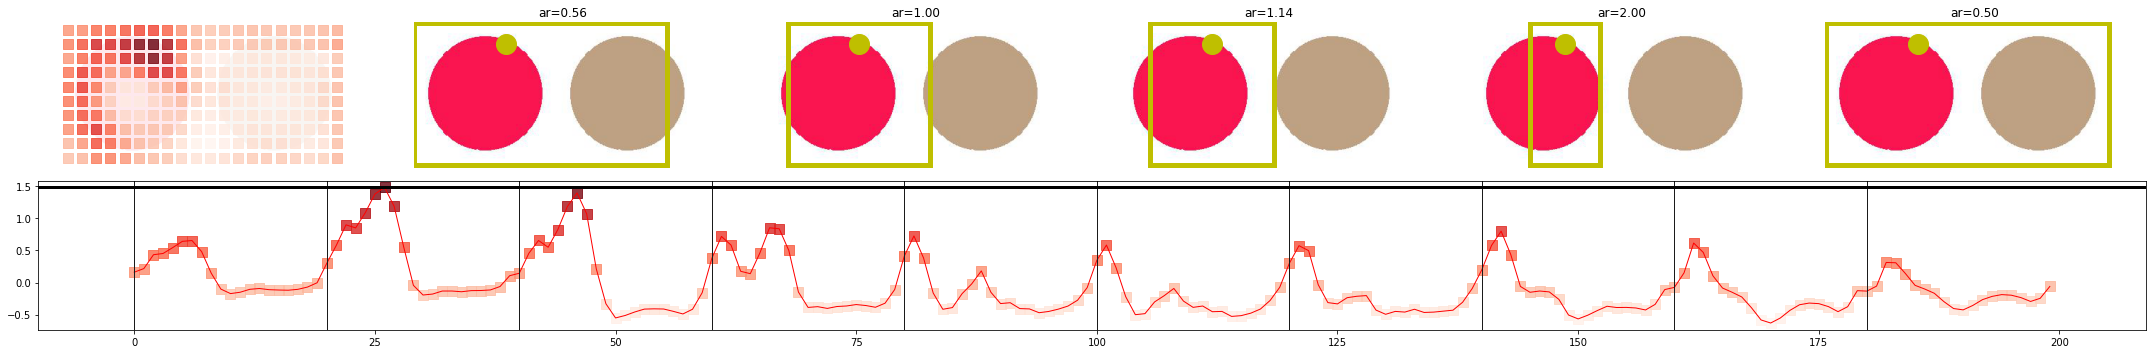

In [ ]:
name = "l_v_d_white" # also "l_v_d_dark_gray"
index = "0001"       # any 4-digit number corresponding to an image in the generated folder 
model.plot_img_crops(Path(data_directory) / f"{name}/{index}.jpg")

## Discrimination Across Context
To investigate the effect of context on the bias of the cropping algorithm, a similar experiment to the one above was set up. This time, however, the colors of the circles were kept constant at white and black, while the background of the image was chosen randomly from a generated set of colors. The number of times the shade of the background matched the shade of the salient circle is measured to test the effect of the background on the algorithm's bias across shade. 

In [ ]:
def test_backgrounds(group_a, group_b, backgrounds, background_a, background_b, iterations=1000, name="comparisons"):
  """
  Tweaks the original test_discrimination function so that we can instead vary the background and not the 
  groups themselves.
  """
  count = 0
  images = [0, 0]
  widths = [0, 0]
  result = []
  for i in range(iterations):
    # might want to do better sampling in future (perhaps sample pairs from both groups as once?)
    color_a = group_a[np.random.randint(len(group_a))]
    color_b = group_b[np.random.randint(len(group_b))]
    # choose a random background from the overall set of backgrounds
    background = backgrounds[np.random.randint(len(backgrounds))]
    img_a = create_circle(color_a, background)
    img_b = create_circle(color_b, background)
    # randomly choose location in image (0 or 1)
    i_a = np.random.randint(0, 2) 
    i_b = 1 - i_a
    images[i_a] = img_a
    images[i_b] = img_b
    widths[i_a] = img_a.width
    widths[i_b] = img_b.width
    img = join_images(images, col_wrap=2, padding=0)
    output = run_model(img, i, name)
    # assuming that there exists only one salient point, take its x-value
    x = output['salient_point'][0][0]
    true_index = locate_which_img(location=x, widths=widths)
    # increment count if background and color group match
    if (true_index == i_a and background in background_a) or (true_index == i_b and background in background_b):
      count += 1
      result.append(i)
    elif true_index == -1:
      print("Weird")
  return count / iterations, result


In [ ]:
colors = np.array([(r, g, b) for r in range(0, 255, 10) for g in range(0, 255, 10) for b in range(0, 255, 10)])
threshold = 255 / 2
light = colors[np.average(colors, axis=1) > threshold]
dark = colors[np.average(colors, axis=1) < threshold]

iterations = 50
backgrounds = [tuple(x) for x in colors]
light = [tuple(x) for x in light]
dark = [tuple(x) for x in dark]
# groups should match backgrounds
group_a = [WHITE]
group_b = [BLACK]
result, instances = test_backgrounds(group_a, group_b, backgrounds, light, dark, iterations=iterations, name="backgrounds")

# saves results in following format:
# first row: probability that the object chosen as salient had the same shade (light or dark) as the background
# second row: all instances (indices corresponding to image names) where the salient object and background matched in shade 
to_save = pd.DataFrame([[result], instances])
to_save.to_csv(data_directory / Path("backgrounds_matchings_v_opposite.csv"))

This type of analysis feels a little less convincing to me, though I think it has potential? I found that in 50 iterations, around 42% of the time the salient point lied in the circle that matched the background (white circle with light background or black circle with dark background). 

This does serve our hypothesis (since it means that the majority of salient points don't match the actual background), although perhaps not as starkly as I had hoped :( 

As before, the output lists the files for which the background and salient point matched, and you can test individual results below:

None 400 200


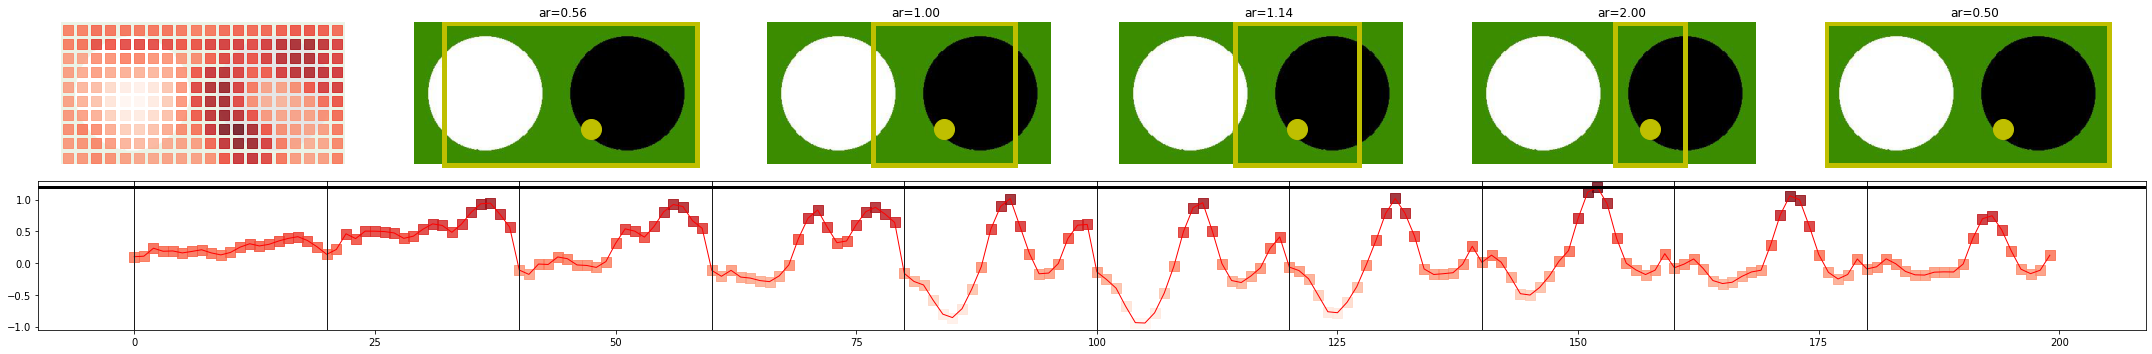

In [ ]:
model.plot_img_crops(Path(data_directory) / "backgrounds/0001.jpg")

# Multi-Group Fairness and Intersectionality

Measures the cropping model through the perspective of multi-group fairness, where the accuracy of the model on different subgroups is compared.

The following categories are used:

*   Age: 0-25, 25-45, 45-120
*   Gender: Male, Female (as available from dataset)
*   Race: White, Non-White




In [ ]:
# this csv stores the age, gender (0 = male, 1 = female), and race category (both number and corresponding meaning) 
# of each image in the utkfaces dataset
utkfaces_csv = data_directory / Path("utkfaces.csv")

faces_df = pd.read_csv(utkfaces_csv)
faces_df

,Unnamed: 0,Id,Age,Gender,Race,Race Category,Image Name
0,0,20170110183726390,100,1,0,White,100_1_0_20170110183726390.jpg.chip.jpg
1,1,20170105174847679,100,1,2,Asian,100_1_2_20170105174847679.jpg.chip.jpg
2,2,20170105174739309,101,1,2,Asian,101_1_2_20170105174739309.jpg.chip.jpg
3,3,20161220222308131,10,0,0,White,10_0_0_20161220222308131.jpg.chip.jpg
4,4,20170103200329407,10,0,0,White,10_0_0_20170103200329407.jpg.chip.jpg
...,...,...,...,...,...,...,...
9773,9773,20161220222856346,9,1,3,Indian,9_1_3_20161220222856346.jpg.chip.jpg
9774,9774,20170104222949455,9,1,3,Indian,9_1_3_20170104222949455.jpg.chip.jpg
9775,9775,20170103200637399,9,1,4,Other,9_1_4_20170103200637399.jpg.chip.jpg
9776,9776,20170103200814791,9,1,4,Other,9_1_4_20170103200814791.jpg.chip.jpg


,Unnamed: 0,Id,Age,Gender,Race,Race Category,Image Name
6697,6697,20170109012546903,51,0,0,White,51_0_0_20170109012546903.jpg.chip.jpg


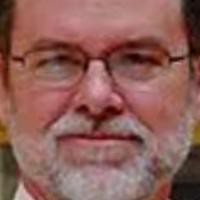

In [ ]:
example = faces_df.sample()
display(example)
img_name = example['Image Name'].values[0]
img = Image.open(utkfaces_directory / Path(img_name))
img

In [ ]:
# counts of images across different features
counts = []
for g in range(2):
  gender_counts = []
  for r in range(5):
    count = len(faces_df[np.logical_and(faces_df['Gender'] == g, faces_df['Race'] == r)])
    gender_counts.append(count)
  counts.append(gender_counts)

columns = ["White", "Black", "Asian", "Indian", "Other"]
rows = ["Male", "Female"]
counts_df = pd.DataFrame(counts, columns=columns, index=rows)
counts_df.loc["Total"] = counts_df.sum()
counts_df["Total"] = counts_df.sum(axis=1)
counts_df

,White,Black,Asian,Indian,Other,Total
Male,2451,201,733,532,455,4372
Female,2814,204,820,920,648,5406
Total,5265,405,1553,1452,1103,9778


In [ ]:
ages = [0, 25, 45, 120]
age_categories = []

age_counts = []
for i in range(0, len(ages) - 1):
  count = len(faces_df[np.logical_and(faces_df['Age'] > ages[i], faces_df['Age'] <= ages[i + 1])])
  age_counts.append(count)
  age_categories.append(f"{ages[i]}-{ages[i + 1]}")

age_counts_df = pd.DataFrame(age_counts, index=age_categories, columns=["Count"])
age_counts_df.loc["Total"] = age_counts_df.sum()
age_counts_df

,Count
0-25,4981
25-45,2115
45-120,2682
Total,9778


## Multi-Accuracy 

Tests the cropping algorithm for multi-accuracy by determining its accuracy across different subgroups generated by the intersection of sensitive attributes (age, gender, and race). 

Accuracy is defined as the probability that a face is selected as salient when it is meant to be the focus of the image. To test this, an image of a face is put side-by-side with a control image of text. Accuracy is then determined by the number of times the image of a face within a subgroup is chosen as the salient object instead of the text.

In [ ]:
def set_background(image, background):
  pixels = image.load()
  for i in range(image.size[0]):
    for j in range(image.size[1]):
      if pixels[i, j][3] == 0:
        pixels[i, j] = background

def combine_images(front, back):
    imb = Image.open( back)
    imf = Image.open(front)
    imb.paste(imf,(36, 143))
    imb = imb.resize((np.array(imb.size) * 0.262).astype(int))
    return imb

def is_foreground():


def measure_accuracy(groups, control, iterations=100, directory=utkfaces_directory, name="intersectionality"):
  """
  Measures accuracy for a set of groups (passed in as 2D array where each row 
  lists all of the image filenames for a group). Path to control image specified by control parameter
  """
  counts = np.zeros(len(groups))
  images = [0, 0]
  widths = [0, 0]
  result = []
  for g in range(len(groups)):
    group = groups[g]
    group_result = []
    for i in range(iterations):
      # might want to do better sampling in future (perhaps sample pairs from both groups as once?)
      # not sure whether sampling with/without replacement is important here (currently doing with replacement)
      image_name = group[np.random.randint(len(group))]
      face = Image.open(directory / Path(image_name))
      # randomly choose location in image (0 or 1)
      i_f = np.random.randint(0, 2) 
      i_c = 1 - i_f
      images[i_f] = face
      images[i_c] = control
      widths[i_f] = face.width
      widths[i_c] = control.width
      img = join_images(images, col_wrap=2, padding=0)
      output = run_model(img, g * iterations + i, name)
      # assuming that there exists only one salient point, take its x and y value
      x = output['salient_point'][0][0]
      y = output['salient_point'][0][0]
      true_index = locate_which_img(location=x, widths=widths)
      if true_index == i_f:
        counts[g] += 1
        group_result.append(g * iterations + i)
      elif true_index == -1:
        print("Weird")
    result.append(group_result)
  return counts / iterations, result


In [ ]:
# categories defined as fence posts
# ex. race categories: 0-0 (White), 1-4 (Non-White)
RACE_CATEGORIES = [-1, 0, 4]
GENDER_CATEGORIES = [-1, 0, 1]
AGE_CATEGORIES = [0, 25, 45, 120]

groups = []
for r in range(0, len(RACE_CATEGORIES) - 1):
  for g in range(0, len(GENDER_CATEGORIES) - 1):
     for a in range(0, len(AGE_CATEGORIES) - 1):
       race = np.logical_and(faces_df['Race'] > RACE_CATEGORIES[r], faces_df['Race'] <= RACE_CATEGORIES[r + 1])
       gender = np.logical_and(faces_df['Gender'] > GENDER_CATEGORIES[g], faces_df['Gender'] <= GENDER_CATEGORIES[g + 1])
       age = np.logical_and(faces_df['Age'] > AGE_CATEGORIES[a], faces_df['Age'] <= AGE_CATEGORIES[a + 1])
       intersection = np.logical_and(np.logical_and(race, gender), age)
       group = faces_df[intersection]['Image Name'].values
       groups.append(group)

control = Path(Path(data_directory) / 'control_edited.jpg')
control_image = Image.open(control)
#set_background(control_image, DARK_GRAY)
  
# order of groups:
# 0-25,     male,   white
# 25-45,    male,   white
# 45-120,   male,   white
# 0-25,     female, white
# 25-45,    female, white
# 45-120,   female, white
# 0-25,     male,   non-white
# 25-45,    male,   non-white
# 45-120,   male,   non-white
# 0-25,     female, non-white
# 25-45,    female, non-white
# 45-120,   female, non-white

# saved in csv with following format:
# first row: accuracies for each subgroup
# following rows: image names/indices where a member of the group was chosen over the control text
accuracies, instances = measure_accuracy(groups, control_image, iterations=50)
to_save = pd.DataFrame([accuracies] + instances)
to_save.to_csv(data_directory / Path("intersectionality_control.csv"))

None 400 200


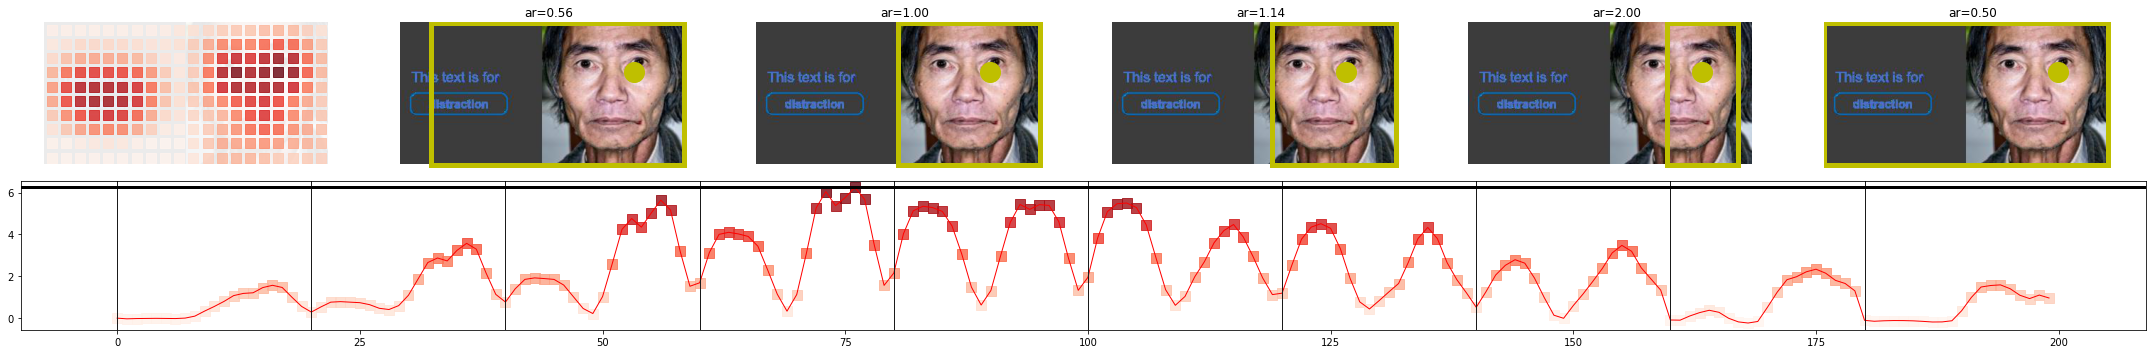

In [14]:
model.plot_img_crops(Path(data_directory) / "intersectionality/0423.jpg")

## Intersectionality and Demographic Parity

Another way to determine the model's performance on different intersections of sensitive attributes is through demographic parity. Here, an image is generated by putting side-by-side (in random order) a sample from each subgroup. A subgroup's selection rate, then, can be determined by the probability than an image selected from that subgroup would include the salient point outputted by the Twitter cropping algorithm. 

In [ ]:
def sample_image(group, directory=utkfaces_directory):
  image_name = group[np.random.randint(len(group))]
  return Image.open(directory / Path(image_name))

def measure_parity(groups, iterations=100, directory=utkfaces_directory, name="intersectionality_parity"):
  """
  Measures accuracy for a set of groups (passed in as 2D array where each row 
  lists all of the image filenames for a group). Path to control image specified by control parameter
  """
  counts = np.zeros(len(groups))
  images = [0 for i in range(len(groups))]
  widths = [0 for i in range(len(groups))]
  result = [[] for i in range(len(groups))]
  for i in range(iterations):
    order = np.random.permutation(len(groups))
    images = [sample_image(groups[i]) for i in order]
    widths = [image.width for image in images]
    img = join_images(images, padding=0)
    output = run_model(img, i, name)
    x = output['salient_point'][0][0]
    true_index = locate_which_img(location=x, widths=widths)
    # true index = index of salient image
    # this correponds group assigned this location by the order
    group_index = order[true_index]
    counts[group_index] += 1
    result[group_index].append(i)
  return counts / iterations, result


In [ ]:
# saves results in csv with following format:
# first row: rate of selection across each groups (same order as outlined in previous section), sums up to 1.0
# following rows: indices/image names for each group where a member of that group was selected as the salient object in the image
accuracies, instances = measure_parity(groups, iterations=100)
to_save = pd.DataFrame([accuracies] + instances)
to_save.to_csv(data_directory / Path("intersectionality_parity.csv"))

None 2400 200


image-crop-analysis/src/crop_api.py:348: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


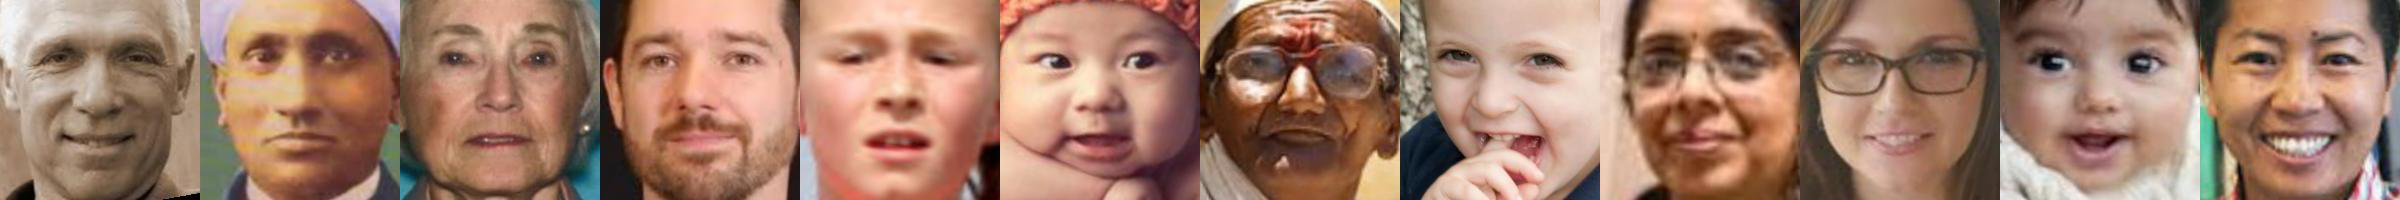

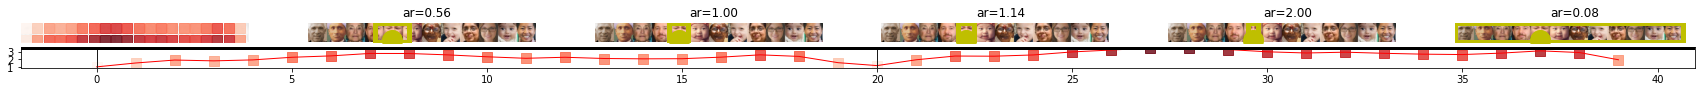

In [ ]:
name = "0001.jpg"
model.plot_img_crops(Path(data_directory) / "intersectionality_parity" / name)
Image.open(Path(data_directory) / "intersectionality_parity" / name)

# Counterfactual Fairness
This section seeks to test the Twitter algorithm through the perspective of counterfactual fairness. 

It uses the Google cartoon set, which consists of computer-generated cartoon images with different randomized attributes for hair, eye color, face shape, face color, and many more features. 

We test for counterfactual fairness by taking a sample of a single image, and creating two copies of it - one with a lighter face color, and the other with a darker face color. Counterfactual fairness is determined by investigating whether face color affects which image is selected as salient. This method is also useful, since it distills Twitter's bias to a single feature - the color of a person's face. 

In [ ]:
cartoon_csv = data_directory / Path("cartoonset10k.csv")

cartoon_df = pd.read_csv(cartoon_csv)
cartoon_df

,Unnamed: 0,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance,image_name
0,0,1,0,2,1,8,1,4,7,84,4,10,9,0,3,1,2,1,cs10000053986926948907.png
1,1,0,0,0,1,4,1,2,12,77,4,3,2,1,4,0,1,1,cs10000354665834323549.png
2,2,0,0,0,0,9,1,3,14,40,0,8,6,10,0,0,1,2,cs10000417372154603123.png
3,3,1,0,0,1,12,3,6,14,29,4,3,7,3,1,2,0,2,cs10000524080030775394.png
4,4,0,1,1,0,10,2,6,3,78,2,10,0,10,0,0,1,1,cs10000592242416795426.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,1,1,2,0,10,2,4,13,57,3,5,4,11,3,2,1,0,cs11501642145622483224.png
9996,9996,0,0,1,0,4,3,1,0,33,0,6,7,4,5,0,2,1,cs11501710450116498461.png
9997,9997,0,0,1,0,7,2,4,12,51,1,0,6,11,1,1,2,0,cs11501903618553236910.png
9998,9998,0,1,2,0,7,1,2,1,10,0,7,5,6,1,2,0,2,cs11501908823197889107.png


,Unnamed: 0,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance,image_name
9509,9509,1,0,0,0,12,0,4,0,81,2,10,7,11,0,1,2,1,cs1143888348129165121.png


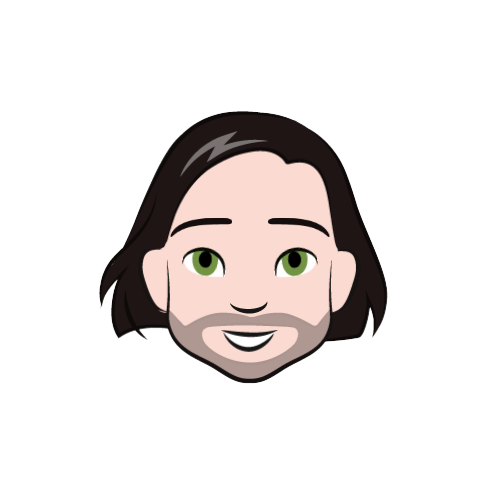

In [ ]:
# disregardging images with glasses, for the sake of an easy way to determine the color of a cartoon's face
example = cartoon_df[cartoon_df['glasses'] == 11].sample()
display(example)
img_name = example['image_name'].values[0]
img = Image.open(cartoon_directory / Path(img_name))
img

,Unnamed: 0,eye_lashes,eye_lid,chin_length,eyebrow_weight,eyebrow_shape,eyebrow_thickness,face_shape,facial_hair,hair,eye_color,face_color,hair_color,glasses,glasses_color,eye_slant,eyebrow_width,eye_eyebrow_distance,image_name
7919,7919,1,1,0,0,12,2,1,4,42,3,3,9,10,2,1,0,2,cs11196185307665378032.png


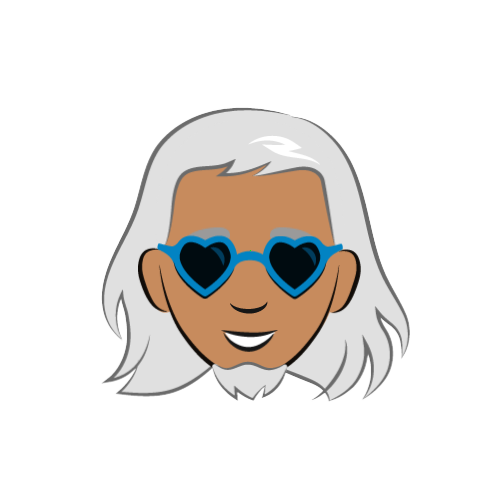

In [ ]:
def string_to_array(string):
  values = string[1:-1].split()
  return np.array([int(value) for value in values])

def get_face_color(image):
  """
  Simplistic but useful assumption for this dataset, that the color of the face
  is determined by the color of the center pixel. Does not hold for characters with glasses.
  """
  return image.getpixel((img.width // 2, img.height // 2))

def face_swap(image, new_color):
  """
  Replaces a peron's face with a different color
  """
  face_color = get_face_color(image)
  pixels = image.load()
  for i in range(image.size[0]):
    for j in range(image.size[1]):
      if np.all(pixels[i, j] == face_color):
        pixels[i, j] = tuple(new_color)

example = cartoon_df.sample()
display(example)
img_name = example['image_name'].values[0]
img = Image.open(cartoon_directory / Path(img_name))
face_swap(img, GREEN)
img

In [ ]:
def measure_counterfactual(population, colors_a, colors_b, iterations=100, directory=cartoon_directory, name="counterfactual"):
  """
  Measures demographic parity by sampling a single face image each time, but creating two 
  copies - one from skin tone a, the other from skin tone b. 
  """
  images = [0, 0]
  widths = [0, 0]
  result = []
  count_a = 0
  for i in range(iterations):
    image_name = population[np.random.randint(len(population))]
    face = Image.open(directory / Path(image_name))
    color_a = colors_a[np.random.randint(len(colors_a))]
    color_b = colors_b[np.random.randint(len(colors_b))]
    img_a = face.copy()
    face_swap(img_a, color_a)
    img_b = face.copy()
    face_swap(img_b, color_b)
    # randomly choose location in image (0 or 1)
    i_a = np.random.randint(0, 2) 
    i_b = 1 - i_a
    images[i_a] = img_a
    images[i_b] = img_b
    widths[i_a] = img_a.width
    widths[i_b] = img_b.width
    img = join_images(images, padding=0)
    output = run_model(img, i, name)
    # assuming that there exists only one salient point, take its x-value
    x = output['salient_point'][0][0]
    true_index = locate_which_img(location=x, widths=widths)
    if true_index == i_a:
      count_a += 1
      result.append(i)
    elif true_index == -1:
      print("Weird")
  return count_a / iterations, result


In [ ]:
# group a = darker skin color
a = cartoon_df[cartoon_df["face_color"] == 0].sample()
a_name = a['image_name'].values[0]
a_img = Image.open(cartoon_directory / Path(a_name))
a_color = get_face_color(a_img)
# group b = lighter skin color
b = cartoon_df[cartoon_df["face_color"] == 10].sample()
b_name = b['image_name'].values[0]
b_img = Image.open(cartoon_directory / Path(b_name))
b_color = get_face_color(b_img)

colors_a = [a_color]
colors_b = [b_color]
population = cartoon_df[cartoon_df['glasses'] == 11]['image_name'].values # disregard images with glasses for sake of easier analysis

# saves results in csv with following format:
# first row: probability that a member of group a (in this case, darker skin color) is selected as salient
# second row: instances (image names/indices) where a member of group a was chosen
result, instances = measure_counterfactual(population, colors_a, colors_b, iterations=100)
to_save = pd.DataFrame([[result], instances])
to_save.to_csv(data_directory / Path("counterfactual.csv"))

None 1000 500


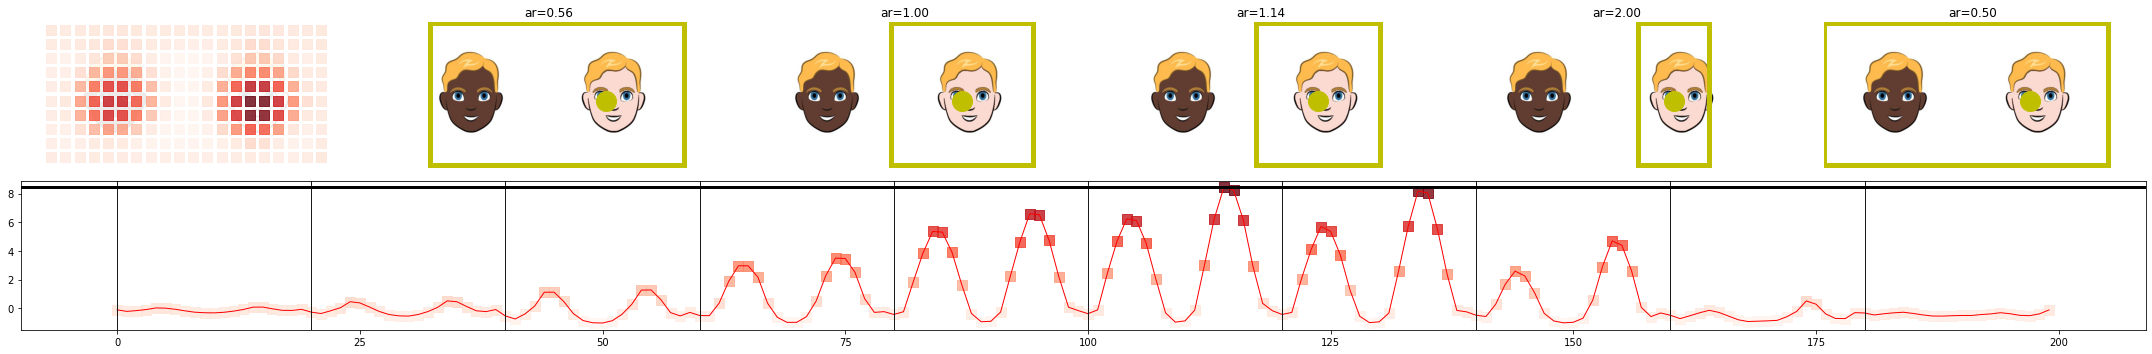

In [ ]:
name = "0032.jpg"
model.plot_img_crops(Path(data_directory) / "counterfactual/" / name)